load the file 

In [9]:
import pandas as pd 
df = pd.read_csv('/home/gdt-ws4/Downloads/protein_bond.csv')

In [ ]:
# # Read the text file line by line
# with open('disulfide.txt', 'r') as file:
#     for line in file:
#         # Split each line by spaces
#         values = line.split(' ')
#         print(values)
#         # Process the values as needed
       

In [ ]:
# # Initialize a list to store data
# data_list = []
# current_data = []

# # Read the text file line by line
# with open('disulfide.txt', 'r') as file:
#     for line in file:
#         line = line.strip()  # Remove leading/trailing whitespace
#         if line:
#             # Append the line to the current_data list
#             current_data.append(line)
#         else:
#             # If a blank line is encountered, append the current_data list to the data_list
#             if current_data:
#                 data_list.append(current_data)
#             current_data = []  # Create a new list for the next section

# # Append the last section to the data_list if not empty
# if current_data:
#     data_list.append(current_data)

# # Display the list of lists
# for section_data in data_list:
#     print(section_data)


In [2]:
df.columns

Index(['Unnamed: 0', 'prot_id', 'protein_seq', 'secondary_structure',
       'number_of_bonds'],
      dtype='object')

Plot the Data

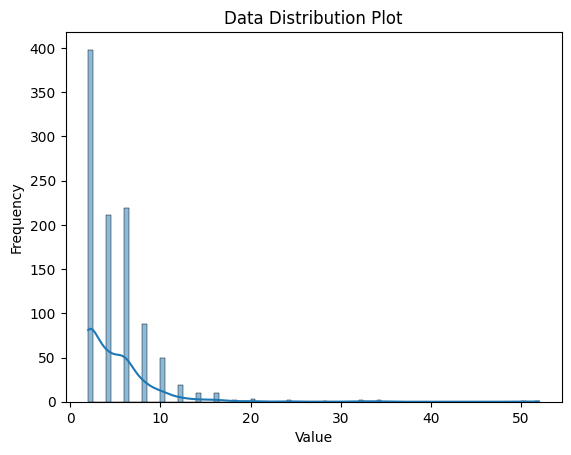

<Figure size 640x480 with 0 Axes>

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df['number_of_bonds'], bins=100, kde=True)  # Adjust the number of bins as needed

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Data Distribution Plot')

# Display the plot
plt.show()
plt.savefig('data_dis.png')

Get the length of each protein sequence length

In [20]:
df['seq_len'] = df['protein_seq'].apply(len)

In [70]:
max_sequence_length = max(len(seq) for seq in all_dot_products)

# Pad sequences to the maximum length
padded_sequences = pad_sequences(all, maxlen=max_sequence_length, padding='post', truncating='post', dtype='float32')

# Convert the padded_sequences list to a numpy array
X = np.array(padded_sequences)

# Convert the delta_g_values to a numpy array
# y = np.array(delta_g_values)

In [57]:
df.columns

Index(['prot_id', 'Feature1', 'Unnamed: 0', 'protein_seq',
       'secondary_structure', 'number_of_bonds', 'letter', 'seq_len',
       'target'],
      dtype='object')

converted the target sequence 

In [48]:
df['target'] = (df['number_of_bonds']/df['seq_len']) *10

In [49]:
df['target']

0       0.246914
1       0.119048
2       0.519481
3       0.038685
4       0.106383
          ...   
1013    0.370370
1014    0.046512
1015    0.035778
1016    0.027100
1017    0.952381
Name: target, Length: 1018, dtype: float64

In [26]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

2023-09-08 16:22:05.534810: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 16:22:06.117082: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [114]:
import numpy as np

# Define your list of amino acids
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# Create a dictionary to map amino acids to indices
aa_to_index = {aa: i for i, aa in enumerate(amino_acids)}

# Function to one-hot encode a sequence
def one_hot_encode_sequence(sequence):
    sequence_length = len(sequence)
    num_classes = len(amino_acids)
    one_hot_encoded = np.zeros((sequence_length, num_classes))
    
    for i, aa in enumerate(sequence):
        if aa in aa_to_index:
            one_hot_encoded[i, aa_to_index[aa]] = 1
        else:
            # Handle the case where the amino acid is not in the dictionary
            # You can choose to ignore it, set a default value, or perform some other action
            pass
    
    return one_hot_encoded

# Example protein sequences
protein_sequences = df['protein_seq']
# Encode the sequences
encoded_seq = [one_hot_encode_sequence(seq) for seq in protein_sequences]
structures = df['secondary_structure']
encoded_structure = [one_hot_encode_sequence(seq) for seq in structures]
import numpy as np

all_dot_products = []

for i in range(len(encoded_seq)):
    encoded = encoded_structure[i].T
    all_dot = np.dot(encoded, encoded_seq[i])
    all_dot_products.append(all_dot)


In [115]:
X = np.array(all_dot_products)

In [112]:
y = df['target']
y = np.array(y)

In [113]:
# Split the data into 70% training and 30% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3,random_state=42)

# # Split the remaining data (30%) into 10% validation and 20% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, random_state=42)

# # Print the shapes of the datasets
print("Training data shapes:", X_train.shape, y_train.shape)
print("Validation data shapes:", X_val.shape, y_val.shape)
print("Test data shapes:", X_test.shape, y_test.shape)


Training data shapes: (712, 20, 20) (712,)
Validation data shapes: (100, 20, 20) (100,)
Test data shapes: (206, 20, 20) (206,)


In [116]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

# Set the input shape and number of classes (1 for regression)
input_shape = (X_train.shape[1],X_train.shape[2]) # Sequence length and number of channels
num_classes = 1

# Create the model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=1))  # Keep this pooling layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='linear'))


# Compile the model with appropriate loss function and optimizer
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# Apply learning rate scheduling
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)

# Train the model using the training dataset and validate on the validation set
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[lr_scheduler])

# Evaluate the model on the test dataset
test_loss = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)


Epoch 1/100
23/23 [==============================] - 0s 5ms/step - loss: 1.2829 - val_loss: 0.5045 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 0.5029 - val_loss: 0.2214 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 0.1991 - val_loss: 0.0909 - lr: 0.0010
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 0.1052 - val_loss: 0.0673 - lr: 0.0010
Epoch 5/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0794 - val_loss: 0.0566 - lr: 0.0010
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0695 - val_loss: 0.0529 - lr: 0.0010
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0620 - val_loss: 0.0589 - lr: 0.0010
Epoch 8/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0557 - lr: 0.0010
Epoch 9/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.0543 - lr:

In [117]:
# Assuming you have predictions and true values as numpy arrays
prediction = model.predict(X_test)
y_true = np.array(y_test)  # True delta_G values for the test data
y_pred = prediction.reshape(-1)  # Reshape predictions to a 1D array if needed

# Calculate mean squared error (MSE)
mse = mean_squared_error(y_true, y_pred)

# Calculate coefficient of determination (R-squared score)
r2_score_value = r2_score(y_true, y_pred)

# Print the results
print("Mean Squared Error (MSE):", mse)
print("R-squared Score:", r2_score_value)


7/7 [==============================] - 0s 961us/step
Mean Squared Error (MSE): 0.04945432708851938
R-squared Score: 0.9094707724784448


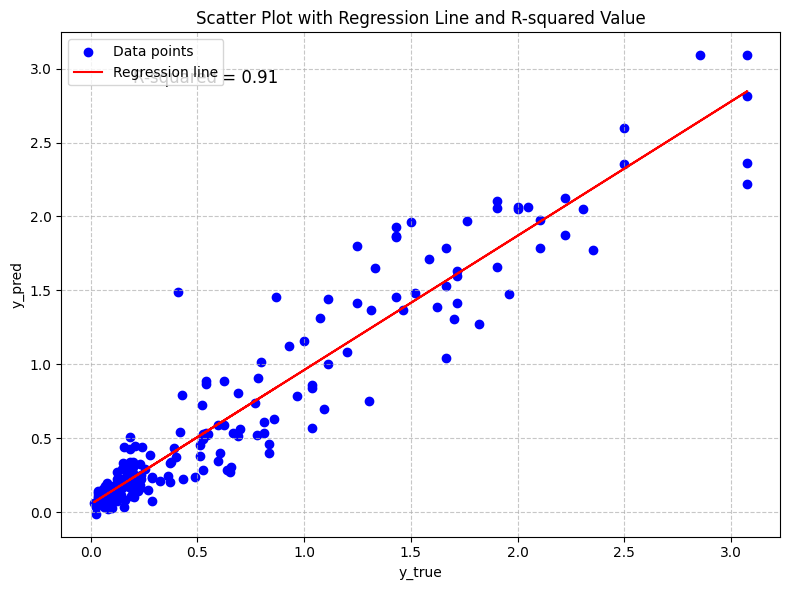

In [118]:
import matplotlib.pyplot as plt
regression_line = np.polyfit(y_true, y_pred, 1)
regression_fn = np.poly1d(regression_line)

# Calculate the R-squared value
r2 = r2_score(y_true, y_pred)

# Create a scatter plot with regression line and R-squared value
plt.figure(figsize=(8, 6))

plt.scatter(y_true, y_pred, color='blue', label='Data points')
plt.plot(y_true, regression_fn(y_true), color='red', label='Regression line')

# Annotate with R-squared value
plt.annotate(f'R-squared = {r2:.2f}', (0.1, 0.9), xycoords='axes fraction', fontsize=12)

plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.title('Scatter Plot with Regression Line and R-squared Value')
plt.legend()

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



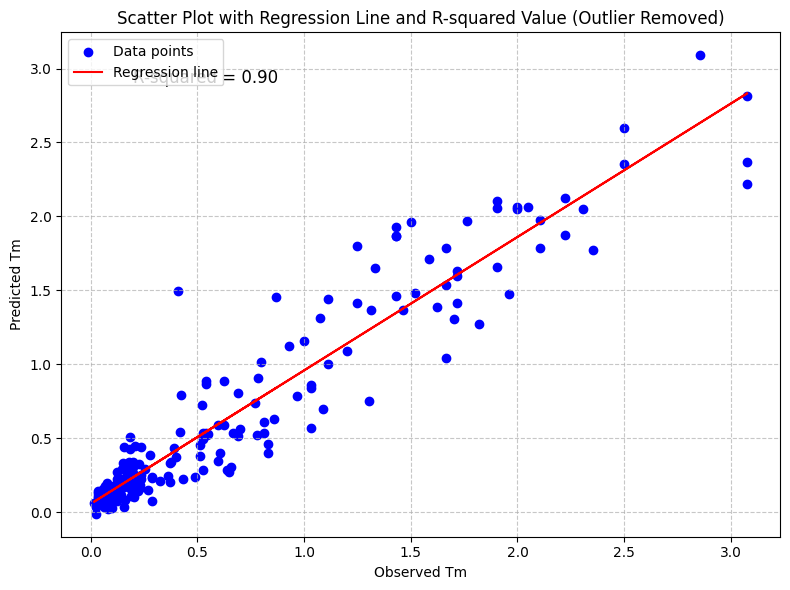

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
outlier_index = np.argmax(y_pred)  # Find the index of the outlier
y_true = np.delete(y_true, outlier_index)
y_pred = np.delete(y_pred, outlier_index)

# Calculate the regression line and R-squared value after removing the outlier
regression_line = np.polyfit(y_true, y_pred, 1)
regression_fn = np.poly1d(regression_line)
r2 = r2_score(y_true, y_pred)

# Create a scatter plot with regression line and R-squared value
plt.figure(figsize=(8, 6))

plt.scatter(y_true, y_pred, color='blue', label='Data points')
plt.plot(y_true, regression_fn(y_true), color='red', label='Regression line')

# Annotate with R-squared value
plt.annotate(f'R-squared = {r2:.2f}', (0.1, 0.9), xycoords='axes fraction', fontsize=12)

plt.xlabel('Observed Tm')
plt.ylabel('Predicted Tm')
plt.title('Scatter Plot with Regression Line and R-squared Value (Outlier Removed)')
plt.legend()

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [97]:
model.save('di_sulphite_bond.h5')